In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm

from models.blstm.blstm import BLSTM 
from utils.data_loader import DiacritizationDataset

In [ ]:
!pip install gdown --upgrade
!gdown https://drive.google.com/uc?id=1He1Zv5SkAE2BBrld50zdQO8Ap8VjluVi
!gdown https://drive.google.com/uc?id=1ALgBlWg4sE2nwIyawAMHMyLd68ddyi_5
!gdown https://drive.google.com/uc?id=1QKtfvQ-isJrqJWLFSQCN2XvN9jB5EM8-
!gdown https://drive.google.com/uc?id=1rbRye8jkI7myGMqXlUWAaxz-KP1SbKHF
!gdown https://drive.google.com/uc?id=1L4efPQpPUnZDlJxNYRpcBGEmBf4osnzg
!gdown https://drive.google.com/uc?id=1w6aSOc5FaHjPcrTqlx8gkYtxkr-InvLI

Downloading...
From (original): https://drive.google.com/uc?id=1PvTJa9OQN1QB3s0nHSUcxsqhFYLPq5Nf
From (redirected): https://drive.google.com/uc?id=1PvTJa9OQN1QB3s0nHSUcxsqhFYLPq5Nf&confirm=t&uuid=3b98f8d4-1f08-4f5d-868c-44e5e0130b79
To: /kaggle/working/X_train.npy
100%|█████████████████████████████████████████| 916M/916M [00:03<00:00, 239MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1ytNbwdJCMZbKIFW6Jxy2KBijIN2ongDH
From (redirected): https://drive.google.com/uc?id=1ytNbwdJCMZbKIFW6Jxy2KBijIN2ongDH&confirm=t&uuid=46808a72-383c-4050-8466-3cafa6819d42
To: /kaggle/working/y_train.npy
100%|█████████████████████████████████████████| 916M/916M [00:03<00:00, 232MB/s]
Downloading...
From: https://drive.google.com/uc?id=1RUQPbQBxMAhuSVNL_A3_6cAgXvJvhAdw
To: /kaggle/working/y_val.npy
100%|███████████████████████████████████████| 44.5M/44.5M [00:00<00:00, 223MB/s]
Downloading...
From: https://drive.google.com/uc?id=1FcDLb80P6exXNitDOO-IuX-aGWJ31r5X
To: /kaggle/working/X_val

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
def train_model(model, train_loader, val_loader, epochs=10, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss(ignore_index=15)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)
    
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(epochs):
        model.train()

        total_train_loss = 0
        total_train_correct = 0
        total_train_tokens = 0

        with tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]') as pbar:
            for batch_X, batch_y in pbar:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)

                optimizer.zero_grad()

                outputs = model(batch_X)

                B, T, C = outputs.shape
                loss = criterion(outputs.view(B*T, C), batch_y.view(B*T))

                preds = outputs.argmax(dim=-1)
                mask = (batch_y != 15)

                correct = (preds[mask] == batch_y[mask]).sum().item()
                total = mask.sum().item()

                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()

                total_train_loss += loss.item()
                total_train_correct += correct
                total_train_tokens += total

                acc = correct / total if total > 0 else 0.0

                pbar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'Acc': f'{acc:.4f}'
                })

        avg_train_loss = total_train_loss / len(train_loader)
        avg_train_acc = total_train_correct / total_train_tokens

        model.eval()
        total_val_loss = 0
        total_val_correct = 0
        total_val_tokens = 0

        with torch.no_grad():
            with tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} [Val]') as pbar:
                for batch_X, batch_y in pbar:
                    batch_X, batch_y = batch_X.to(device), batch_y.to(device)

                    outputs = model(batch_X)
                    B, T, C = outputs.shape

                    loss = criterion(outputs.view(B*T, C), batch_y.view(B*T))

                    preds = outputs.argmax(dim=-1)
                    mask = (batch_y != 15)

                    correct = (preds[mask] == batch_y[mask]).sum().item()
                    total = mask.sum().item()

                    total_val_loss += loss.item()
                    total_val_correct += correct
                    total_val_tokens += total

                    acc = correct / total if total > 0 else 0.0

                    pbar.set_postfix({
                        'Loss': f'{loss.item():.4f}',
                        'Acc': f'{acc:.4f}'
                    })

        avg_val_loss = total_val_loss / len(val_loader)
        avg_val_acc = total_val_correct / total_val_tokens

        scheduler.step(avg_val_loss)

        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'  Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}')
        print(f'  Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.4f}')
        print(f'  LR: {optimizer.param_groups[0]["lr"]:.6f}')

        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_acc)
        val_losses.append(avg_val_loss)
        val_accuracies.append(avg_val_acc)

    return {
        'train_loss': train_losses,
        'train_accuracy': train_accuracies,
        'val_loss': val_losses,
        'val_accuracy': val_accuracies
    }


In [9]:
X_train = np.load('/kaggle/working/X_train.npy')
y_train = np.load('/kaggle/working/y_train.npy')
X_val = np.load('/kaggle/working/X_val.npy')
y_val = np.load('/kaggle/working/y_val.npy')

In [10]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

X_train shape: (185074, 1237)
y_train shape: (185074, 1237)
X_val shape: (9000, 1237)
y_val shape: (9000, 1237)


In [10]:
vocab_size = len(pickle.load(open('/kaggle/working/letter2idx.pickle', 'rb'))) 
num_classes = len(pickle.load(open('/kaggle/working/diacritic2id.pickle', 'rb')))
print("Vocab size:", vocab_size)
print("Num classes:", num_classes)

Vocab size: 38
Num classes: 16


In [ ]:
import pickle

# Load the letter2idx mapping
with open("letter2idx.pickle", "rb") as file:
    letter2idx = pickle.load(file)

# Create inverse mapping
idx2letter = {value: key for key, value in letter2idx.items()}

print(letter2idx)
print(idx2letter)

In [ ]:
train_dataset = DiacritizationDataset(X_train, y_train, idx2letter)
val_dataset = DiacritizationDataset(X_val, y_val, idx2letter)

In [12]:
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

In [ ]:
model = BLSTM(vocab_size, num_classes).to(device)

In [16]:
model.load_state_dict(torch.load("/kaggle/input/blstm/pytorch/default/1/blstm_model.pth", map_location=device))
model.to(device)
model.eval()

SimpleBLSTM(
  (embedding): Embedding(38, 128, padding_idx=0)
  (bilstm): LSTM(128, 256, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=512, out_features=16, bias=True)
)


Model Summary:
Total parameters: 803,600

Starting training...


Epoch 1/10 [Val]: 100%|██████████| 563/563 [00:15<00:00, 36.39it/s, Loss=0.1438, Acc=0.9661]


Epoch 1/10:
  Train Loss: 0.1941, Train Acc: 0.9370
  Val Loss: 0.1488, Val Acc: 0.9530
  LR: 0.001000


Epoch 2/10 [Val]: 100%|██████████| 563/563 [00:15<00:00, 36.65it/s, Loss=0.1323, Acc=0.9627]


Epoch 2/10:
  Train Loss: 0.1369, Train Acc: 0.9559
  Val Loss: 0.1363, Val Acc: 0.9564
  LR: 0.001000


Epoch 3/10 [Val]: 100%|██████████| 563/563 [00:15<00:00, 36.58it/s, Loss=0.1076, Acc=0.9661]


Epoch 3/10:
  Train Loss: 0.1273, Train Acc: 0.9589
  Val Loss: 0.1304, Val Acc: 0.9589
  LR: 0.001000


Epoch 4/10 [Val]: 100%|██████████| 563/563 [00:15<00:00, 36.55it/s, Loss=0.1066, Acc=0.9695]


Epoch 4/10:
  Train Loss: 0.1227, Train Acc: 0.9604
  Val Loss: 0.1280, Val Acc: 0.9595
  LR: 0.001000


Epoch 5/10 [Val]: 100%|██████████| 563/563 [00:15<00:00, 36.62it/s, Loss=0.1106, Acc=0.9661]


Epoch 5/10:
  Train Loss: 0.1194, Train Acc: 0.9614
  Val Loss: 0.1222, Val Acc: 0.9615
  LR: 0.001000


Epoch 6/10 [Val]: 100%|██████████| 563/563 [00:15<00:00, 36.53it/s, Loss=0.1235, Acc=0.9661]


Epoch 6/10:
  Train Loss: 0.1173, Train Acc: 0.9622
  Val Loss: 0.1230, Val Acc: 0.9608
  LR: 0.001000


Epoch 7/10 [Val]: 100%|██████████| 563/563 [00:15<00:00, 36.49it/s, Loss=0.1016, Acc=0.9627]


Epoch 7/10:
  Train Loss: 0.1155, Train Acc: 0.9628
  Val Loss: 0.1204, Val Acc: 0.9618
  LR: 0.001000


Epoch 8/10 [Val]: 100%|██████████| 563/563 [00:15<00:00, 36.56it/s, Loss=0.1144, Acc=0.9593]


Epoch 8/10:
  Train Loss: 0.1140, Train Acc: 0.9632
  Val Loss: 0.1199, Val Acc: 0.9624
  LR: 0.001000


Epoch 9/10 [Val]: 100%|██████████| 563/563 [00:15<00:00, 36.11it/s, Loss=0.1028, Acc=0.9661]


Epoch 9/10:
  Train Loss: 0.1130, Train Acc: 0.9635
  Val Loss: 0.1187, Val Acc: 0.9626
  LR: 0.001000


Epoch 10/10 [Val]: 100%|██████████| 563/563 [00:15<00:00, 36.37it/s, Loss=0.0956, Acc=0.9695]


Epoch 10/10:
  Train Loss: 0.1117, Train Acc: 0.9639
  Val Loss: 0.1199, Val Acc: 0.9621
  LR: 0.001000


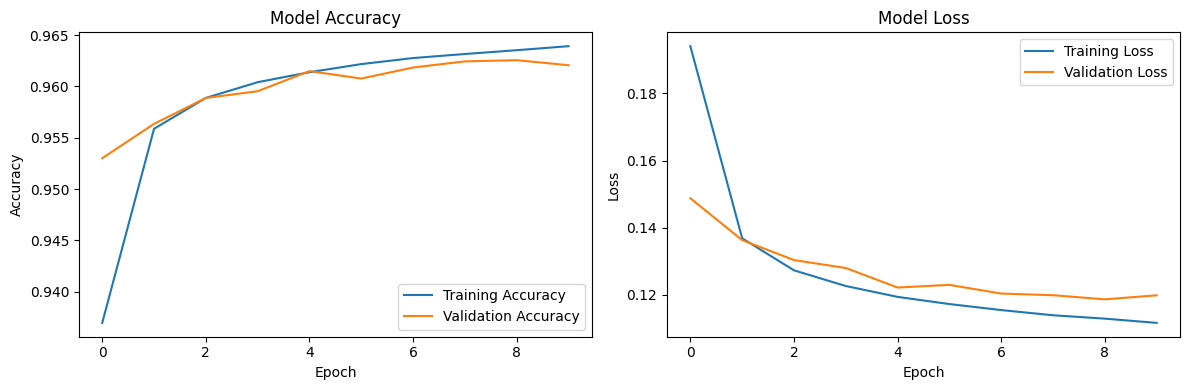

Model saved successfully!


In [15]:
# Print model summary
print("\nModel Summary:")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

# Train model
print("\nStarting training...")
history = train_model(model, train_loader, val_loader, epochs=10)

# Plot results
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Save model
torch.save({
    'model_state_dict': model.state_dict(),
    'vocab_size': vocab_size,
    'num_classes': num_classes,
    'history': history
}, 'blstm_model.pth')

print("Model saved successfully!")

In [23]:
def predict_sentence(model, seq, device):
    model.eval()

    # Convert input text to indices
    #seq = [lett.get(ch, char2idx["UNK"]) for ch in text]

    # Pad to max length
    #if len(seq) < max_len:
     #   seq += [char2idx["PAD"]] * (max_len - len(seq))
    #else:
     #   seq = seq[:max_len]

    # Convert to tensor shape (1, L)
    seq_tensor = torch.tensor(seq, dtype=torch.long).unsqueeze(0).to(device)

    # Forward pass
    with torch.no_grad():
        outputs = model(seq_tensor)           # (1, L, C)
        preds = torch.argmax(outputs, dim=-1) # (1, L)

    preds = preds.squeeze(0).cpu().numpy()
    return preds
    # Decode only original characters (no padded ones)
    #decoded = []
    #for ch, diac_idx in zip(text, preds):
     #   diacritic = idx2diacritic.get(diac_idx, "")
      #  decoded.append(ch + diacritic)

    #return "".join(decoded)


In [25]:
def get_val_score(x,y,model):
    pred=predict_sentence(model,x,device)
    num =0
    correct=0
    for i in range(len(pred)):
        if y[i]!=15:
            num+=1
            if y[i]==pred[i]:
                correct+=1
    return correct,num

In [26]:
accuracy=0
total_correct=0
total_num=0
for i in range(len(X_val)):
    correct,num=get_val_score(X_val[i],y_val[i],model)
    total_correct+=correct
    total_num+=num

accuracy=total_correct/total_num

In [27]:
accuracy

0.9620690257212084

In [47]:
total_correct

495936

In [48]:
total_num

515489

In [60]:
idx2letter[37]

' '

In [46]:
diacritic2id=None
with open("/kaggle/working/diacritic2id.pickle","rb")as file:
    diacritic2id=pickle.load(file)
    print(diacritic2id)
id2diacritic={}
for key,value in diacritic2id.items():
    id2diacritic[value]=key
print(diacritic2id)
print(id2diacritic)

{'َ': 0, 'ً': 1, 'ُ': 2, 'ٌ': 3, 'ِ': 4, 'ٍ': 5, 'ْ': 6, 'ّ': 7, 'َّ': 8, 'ًّ': 9, 'ُّ': 10, 'ٌّ': 11, 'ِّ': 12, 'ٍّ': 13, '': 14, '<PAD>': 15}
{'َ': 0, 'ً': 1, 'ُ': 2, 'ٌ': 3, 'ِ': 4, 'ٍ': 5, 'ْ': 6, 'ّ': 7, 'َّ': 8, 'ًّ': 9, 'ُّ': 10, 'ٌّ': 11, 'ِّ': 12, 'ٍّ': 13, '': 14, '<PAD>': 15}
{0: 'َ', 1: 'ً', 2: 'ُ', 3: 'ٌ', 4: 'ِ', 5: 'ٍ', 6: 'ْ', 7: 'ّ', 8: 'َّ', 9: 'ًّ', 10: 'ُّ', 11: 'ٌّ', 12: 'ِّ', 13: 'ٍّ', 14: '', 15: '<PAD>'}


In [32]:
import torch

# Suppose your model is called 'model'
model_path = '/kaggle/working/blstm_model.pth'

# Save the model's state_dict
torch.save(model.state_dict(), model_path)
print(f"Model saved at {model_path}")


Model saved at /kaggle/working/blstm_model.pth


In [33]:
pred=predict_sentence(model,X_val[0],device)
pred

array([14, 14,  8, ..., 14, 14, 14])

In [34]:
y_val[0]

array([14, 14,  8, ..., 15, 15, 15], dtype=int32)

In [35]:
len(pred)

1237

In [36]:
len(y_val[0])

1237

In [61]:
def create_sentence(x, y, id2diacritic, idx2letter):
    output = ""
    for letter_idx, diac_idx in zip(x, y):

        # ignore padding
        if letter_idx == 13:  
            continue

        letter = idx2letter[letter_idx]
        diac = id2diacritic[diac_idx]

        # If diacritic is empty, append only the letter
        if diac == "" or diac == "<PAD>":   # adjust to your PAD logic
            output += letter
        else:
            output += letter + diac

    return output


In [62]:
pred=predict_sentence(model,X_val[0],device)
correct_sentence=create_sentence(X_val[0],y_val[0],id2diacritic, idx2letter)
correct_sentence

'الشَّهَادَةِ ظَاهِرَةً '

In [63]:
pred_sentence=create_sentence(X_val[0],pred,id2diacritic, idx2letter)
pred_sentence

'الشَّهَادَةِ ظَاهِرَةٌ '

In [64]:
pred_sentence==correct_sentence

False